# Mobility data analysis
Notebook inspired from Open humans project https://www.openhumans.org

Read mobility files from Open humans
https://www.openhumans.org/api/public-data/?source=direct-sharing-138

Author: Liubov
Thanks to Bastian for inspiration from their notebooks 
https://exploratory.openhumans.org/notebooks/?source=Moves%20connection


In [3]:

import json
from pprint import pprint


'''
Functions:
 to estimate the distribution of stop duration
 to estimate the distribution of jump length
'''

def duration_stop_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns sorted distribution of stops duration
        Can be misleading for days w/ lots of travel etc. 
    """
    places_of_day = []
    duration_seq = [] #sequence of durations of stops
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            duration_seq.append([duration])
    duration_seq.sort() 
    return duration_seq 

def len_jumps_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns the distribution of jumps lengths (calculated from lat/long of stops)
    can be misleading for days w/ lots of travel etc. 
    """
    places_of_traj = [] #returns array of all locations during the day
    for i in daily_segments: 
        if i['type'] == 'place':
            place_location = i['place']['location']
            places_of_traj.append([place_location])
    return places_of_traj


def longest_daily_location(daily_segments):
    """
    Function from Bastian (Open Humans)
    
    takes a daily segment log of Moves and returns the 
    lat/long for the location where most time was spent. 
    Can be misleading for days w/ lots of travel etc. 
    But the most quick/dirty solution for now.
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]







# data example
Example of data 
'''

Read mobility files from Open humans

https://www.openhumans.org/api/public-data/?source=direct-sharing-138
  

[{'caloriesIdle': 1679,
  'date': '20130515',
  'lastUpdate': '20151001T012320Z',
  'segments': [{'activities': [{'activity': 'walking',
                                'calories': 3,
                                'distance': 48.0,
                                'duration': 50.0,
                                'endTime': '20130515T131851-0700',
                                'group': 'walking',
                                'manual': False,
                                'startTime': '20130515T131801-0700',
                                'steps': 96,
                                'trackPoints': []}],
                'endTime': '20130515T132742-0700',
                'lastUpdate': '20151001T012320Z',
                'place': {'id': 61807543,
                          'location': {'lat': 33.99882, 'lon': -118.43657},
                          'name': 'Ramuilar HQ',
                          'type': 'home'},
                'startTime': '20130515T131401-0700',
                'type': 'place'},
               {'activities': [{'activity': 'transport',
                                'distance': 3503.0,
                                'duration': 534.0,
                                'endTime': '20130515T133636-0700',
                                'group': 'transport',
                                'manual': False,
                                'startTime': '20130515T132742-0700',
                                'trackPoints': []}],
                'endTime': '20130515T133637-0700',
                'lastUpdate': '20130515T213146Z',
                'startTime': '20130515T132742-0700',
                'type': 'move'},
               {'activities': [{'activity': 'walking',
                                'calories': 5,
                                'distance': 92.0,
                                'duration': 90.0,
                                'endTime': '20130515T134039-0700',
                                'group': 'walking',
                                'manual': False,
                                'startTime': '20130515T133909-0700',
                                'steps': 184,
                                'trackPoints': []}],
                'endTime': '20130515T142848-0700',
                'lastUpdate': '20140301T070136Z',
                'place': {'foursquareCategoryIds': ['4bf58dd8d48988d14e941735'],
                          'foursquareId': '4a6bdc59f964a52020d01fe3',
                          'id': 61855165,
                          'location': {'lat': 33.99050413968406,
                                       'lon': -118.4649780392647},
                          'name': 'Gjelina',
                          'type': 'foursquare'},

# Main questions
We are interested in two spatial and temporal properties: 
1. distribution of length of stops of human trajectories 
2. distribution of length of jumps between two stops 

With these properties we want to see if different people have different distributions of duration of stops and lengths of stops.


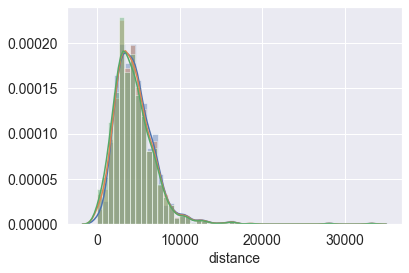

In [15]:
# main function analyzing moves_data    
DATARANGE_START = "2016-06-01"
DATARANGE_END = "2018-05-08"

import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns


# sets the axis label sizes for seaborn
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)

with open('moves-storyline-data.json') as f:
    moves_data = json.load(f)
    
with open('moves-storyline-data98933.json') as f: #uploading different datafiles
    moves_data2 = json.load(f)

with open('moves-storyline-data98972.json') as f:
    moves_data3 = json.load(f)   
    
#for printing this huge file of trajectories:    
#pprint(data)
    

moves_processed_data = defaultdict(list) #empty dict for processed dataframe

'''
function to create new dataframe from the json trajectory file
code adapted from openhumans notebook
'''

def dataframe_from_json(moves_data):
    for datapoint in moves_data:
        # we need to have observed segments for that day. If moves wasn't running we ignore the day
        if datapoint['segments'] != None:
            # did we stay in a place that day and did we walk that day?
            has_places = False
            walked = False
            for i in datapoint['segments']:
                if i['type'] == 'place':
                        # yes, we were in one place w/o moving around too much, we can keep this day
                        has_places = True
                        
            # is this day in our date range of interest and has data?
            if datapoint['summary'] != None and has_places and datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_START,"%Y-%m-%d"):
                moves_processed_data['date'].append(datapoint['date'])
                for activity in datapoint['summary']:
                    if activity['activity'] == 'walking':
                        moves_processed_data['steps'].append(activity['steps'])
                        moves_processed_data['distance'].append(activity['distance'])
                        walked = True
                        
                # in case of not walking, step count is zero
                if not walked:
                    moves_processed_data['steps'].append(0)
                    moves_processed_data['distance'].append(0)  
                    
                # distribution of stops lengths
                stops_distrib = duration_stop_distribution(datapoint['segments'])
                moves_processed_data['duration'].append(stops_distrib)
                location = longest_daily_location(datapoint['segments'])
                moves_processed_data['lat'].append(location['lat'])
                moves_processed_data['lon'].append(location['lon'])    
    
    
    
    #Now that we have all of the data we can convert it into a single pandas dataframe for easier processing and visualization
    
    moves_dataframe = pd.DataFrame(data={
        'date': moves_processed_data['date'],
        'steps': moves_processed_data['steps'],
        'distance': moves_processed_data['distance'],
        'latitude': moves_processed_data['lat'],
        'longitude': moves_processed_data['lon']
    })   
    
    return moves_dataframe

df1 = dataframe_from_json(moves_data)
df2 = dataframe_from_json(moves_data2)
df3 = dataframe_from_json(moves_data3)

#print shape of data
array_distance = df1.distance.values 
type(array_distance)



#Now we plot distribution of moves from new dataframe 
# We compare moves from 1st trajectory and 2nd trajectory

sns.distplot(df1['distance'])
sns.distplot(df2['distance'])
sns.distplot(df3['distance'])
# sns.distplot(stops_distrib)



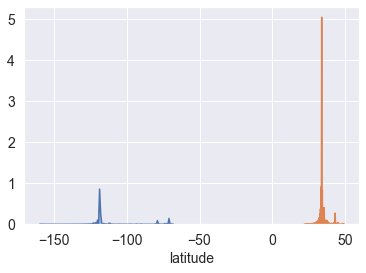

In [13]:
# plot the distribution of latitude and longitude together to make a comparison

sns.distplot(df3['longitude'])
sns.distplot(df3['latitude'])

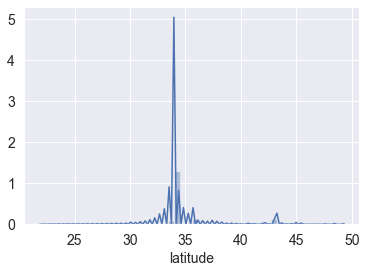

In [17]:
sns.distplot(df3['longitude'])

In [19]:
'''
We plot location of the most popular places from trajectories.
Input:
latitude and longitude from dataframe moves_dataframe
  moves_dataframe = pd.DataFrame(data={
        'date': moves_processed_data['date'],
        'steps': moves_processed_data['steps'],
        'distance': moves_processed_data['distance'],
        'latitude': moves_processed_data['lat'],
        'longitude': moves_processed_data['lon']
    }) 

Output:
Folium map with datapoints
'''

import folium


#first we get trajectory datapoints from the file
latitude = df1.latitude.values
longitude = df1.longitude.values

#then we zip two arrays of lat, lon of datapoints
latlon = zip(latitude, longitude)

#New York 40.7808 et la longitude de la ville de New York City est -73.9772.

#latlon = [ (51.249443914705175, -0.13878830247011467), (51.249443914705175, -0.13878830247011467), (51.249768239976866, -2.8610415615063034)]
mapit = folium.Map( location=[40.7808 , -73.9772], zoom_start=6 )
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )

mapit

By looking at the variation of latitude and longitude coordinates we can see bimodality of trajectories, 
which correspond, most probably to "home" <-> "work". 
We will explore this below using CTRW models.

Bastian did analysis of most popular location data in his notebook for Open humans

https://exploratory.openhumans.org/notebooks/?source=Moves%20connection


In [ ]:
'''
We finally can plot locations moves_processed_data['lat'] on a map of human mobility 
Let us plot the color of each country according to total number of flights in year 2013

For this we first plot basemap
'''
import geopandas as gpd
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from collections import OrderedDict
import networkx as nx
from descartes import PolygonPatch

def plot_function(lat_arr,lon_arr):
    
'''
Plot points from arrays 
lat_arr, lon_arr 
on the world map
'''    
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    
    ll_to_pixel = ccrs.Geodetic()._as_mpl_transform(ax)
    
    # We need to call draw to ensure that the axes location has been defined
    # fully. 
    plt.draw()
    
    # Now lets figure out the pixel coordinate of the city.
    x1_pix = lat_arr[0]
    x2_pix = lat_arr[1]
    y1_pix = lon_arr[0]
    y2_pix = lon_arr[1]    
    x1_pix, y1_pix = ll_to_pixel.transform_point([151.2111, -33.8600])
    x2_pix, y2_pix = ll_to_pixel.transform_point([101.2111, -33.8600])
    
    # We can even plot these pixel coordinates directly with matplotlib.
    plt.plot(x1_pix, y1_pix, 'ob', markersize=25, transform=None)
    plt.plot(x2_pix, y2_pix, 'ob', markersize=25, transform=None)
    
    #plt.savefig('figure_1.png', dpi=plt.gcf().get_dpi())
    plt.show()    


#  Continuous time random walk analysis of trajectories
Continuous time random walk (CTRW) is a generalization of a random walk where the wandering particle waits for a random time between jumps. 
It is a stochastic jump process with arbitrary distributions of jump lengths and waiting times.
More generally it can be seen to be a special case of a Markov renewal process. 

Important properties of CTRW are r(t) and d(t) distributions of lengths of jumps and durations correspondingly. 

For more details look at code and papers here 
https://github.com/Liyubov/networks_random_walking

### Analysis 

We start with  Hurst exponent, which is used as a measure of long-term memory of time series

https://en.wikipedia.org/wiki/Hurst_exponent#Estimating_the_exponent

It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases. 

Given the input, trajectory z(t) =(x(t),y(t)), we first estimate STD, which is just the root of variance so var(τ)=(Var(z(t)-z(t-τ)))

We can write Var(τ) ∝ τ^(2H), where H is the Hurst exponent.
Hence (Var(z(t)-z(t-τ))) ∝ τ^(2H)

Then 
[log (Var(z(t)-z(t-τ))) / log τ ] / 2 ∝ H (gives the Hurst exponent) where we know the term in square brackets on far left is the slope of a log-log plot of tau and a corresponding set of variances.


In [2]:

'''
We adapt here the function to estimate Hurst exponent for trajectories.

First we estimate STD 
Then we estimate Hurst exponent. 

'''
lags = range(2,100)
def hurst_exponen_chan(p):
    '''
    given series p(t), where t is time 
    '''    
    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = subtract(p[lag:], p[:-lag])
        variancetau.append(var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = polyfit(log10(tau),log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

In [12]:
'''
We plot location of the most popular places with latitude and longitude on Folium map
'''
import folium
latlon = [ (51.249443914705175, -0.13878830247011467), (51.249443914705175, -0.13878830247011467), (51.249768239976866, -2.8610415615063034)]
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 )
for coord in latlon:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )

mapit